In [1]:
%autosave 150
%matplotlib inline
import pandas as pd
import numpy as np
import math
import matplotlib.pylab as plt

Autosaving every 150 seconds


# Load Data

In [2]:
def load_movielens_100k():
    # Load users
    u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
    users = pd.read_csv('data/ml-100k/u.user', sep='|', names=u_cols)

    # load ratings
    r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
    ratings = pd.read_csv('data/ml-100k/u.data', sep='\t', names=r_cols)

    # Load movies
    m_cols = ['movie_id', 'title', 'release_date']
    movies = pd.read_csv('data/ml-100k/u.item', sep='|', names=m_cols, usecols=range(3), encoding='latin-1')

    # Join dataframes
    data = pd.merge(pd.merge(ratings, users), movies)
    data = data[['user_id','title', 'movie_id','rating','release_date','sex','age']]


    print("The DB has "+ str(data.shape[0]) +" ratings")
    print("The DB has ", data.user_id.nunique()," users")
    print("The DB has ", data.movie_id.nunique(), " movies")
    print(data.head())
    
    return data, users, ratings, movies

def load_movielens_1M():
    # Load users
    u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
    users = pd.read_csv('data/ml-1m/users.dat', sep='::', names=u_cols)

    # Load ratings
    r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
    ratings = pd.read_csv('data/ml-1m/ratings.dat', sep='::', names=r_cols)

    # Load movies
    m_cols = ['movie_id', 'title', 'release_date']
    movies = pd.read_csv('data/ml-1m/movies.dat', sep='::', names=m_cols, usecols=range(3), encoding='latin-1')

    # Join dataframes
    data = pd.merge(pd.merge(ratings, users), movies)
    data = data[['user_id','title', 'movie_id','rating','release_date','sex','age']]


    print("The DB has "+ str(data.shape[0]) +" ratings")
    print("The DB has ", data.user_id.nunique()," users")
    print("The DB has ", data.movie_id.nunique(), " movies")
    print(data.head())
    
    return data, users, ratings, movies

# Missing value treatment

In [3]:
from sklearn.impute import KNNImputer

def impute_missing_values(df, method="mean", **params):
    if method == "mean":
        return df.mean(), df.fillna(df.mean())
    elif method == "median":
        return df.median(), df.fillna(df.median())
    elif method == "KNN":
        knnimputer = KNNImputer(**params)
        knnimputer.fit(df)
        return knnimputer, knnimputer.transform(df)  

# Item based

In [62]:
data, users, ratings, movies = load_movielens_100k()

The DB has 100000 ratings
The DB has  943  users
The DB has  1682  movies
   user_id         title  movie_id  rating release_date sex  age
0      196  Kolya (1996)       242       3  24-Jan-1997   M   49
1      305  Kolya (1996)       242       5  24-Jan-1997   M   23
2        6  Kolya (1996)       242       4  24-Jan-1997   M   42
3      234  Kolya (1996)       242       4  24-Jan-1997   M   60
4       63  Kolya (1996)       242       3  24-Jan-1997   M   31


In [5]:
user_item_matrix = data.pivot(index='user_id', columns='movie_id', values='rating')
item_user_matrix = data.pivot(index='movie_id', columns='user_id', values='rating')

In [29]:
def slow_similarity(user_item_matrix, u1, u2, measure="cosine"):
    def dot(m, u1, u2):
        return m.loc[u1].dot(m.loc[u2])
    
    if measure == 'cosine':
        return dot(user_item_matrix, u1, u2)/(np.sqrt(dot(user_item_matrix, u1, u1)*dot(user_item_matrix, u2, u2)))
    
    elif measure == 'adj_cosine' or measure=='pearson_correlation':
        mr1 = user_item_matrix.loc[u1].mean()
        mr2 = user_item_matrix.loc[u2].mean()
        common_movies = user_item_matrix.loc[[u1,u2]].isna().sum(axis=0)==0
        common_matrix = user_item_matrix.T[common_movies].T
        return dot(common_matrix, u1, u2)/(np.sqrt(dot(common_matrix, u1, u1)*dot(common_matrix, u2, u2)))
    else:
        print("Method not implemented")
        
def fast_similarity(user_item_matrix, measure="cosine"):
    if measure == 'cosine':
        m = user_item_matrix.dot(user_item_matrix.T)
        norm = np.array([np.sqrt(np.diagonal(m))])
        return (m/norm/norm.T)
    
    elif measure == 'adj_cosine' or measure=='pearson_correlation':
        m = user_item_matrix - user_item_matrix.mean()
        m = m.dot(m.T)
        norm = np.array([np.sqrt(np.diagonal(m))])
        return (m/norm/norm.T)

In [27]:
slow_similarity(user_item_matrix.fillna(user_item_matrix.mean()).T, 10, 11, "cosine")

0.987294941213731

In [28]:
sim_matrix = fast_similarity(user_item_matrix.fillna(user_item_matrix.mean()).T, 'cosine')
sim_matrix.loc[10][11]

0.9872949412137292

In [67]:
def recommend_top_k(k, user_vector, user_item_matrix, measure="cosine", movies_df=movies):
    new_uim = user_item_matrix.copy()
    new_uim.append(user_vector, ignore_index=True)
    sim_matrix = fast_similarity(new_uim, measure)
    scores_vector = sim_matrix.iloc[-1].sort_values(ascending=False)
    idx = scores_vector.iloc[1:k+1].index.tolist() # item 0 is always same item
    return movies_df[movies_df['movie_id'].isin(idx)]['title']

In [68]:
user_item_matrix_nafilled = user_item_matrix.fillna(user_item_matrix.mean())
recommend_top_k(10, user_item_matrix_nafilled[1].T, user_item_matrix_nafilled.T)

1504                   Killer: A Journal of Murder (1995)
1509                                  Mad Dog Time (1996)
1512                                        Sprung (1997)
1514                              Wings of Courage (1995)
1519                                     Fear, The (1995)
1520                                 Mr. Wonderful (1993)
1524                   Object of My Affection, The (1998)
1525                                       Witness (1985)
1531                               Foreign Student (1994)
1532    I Don't Want to Talk About It (De eso no se ha...
Name: title, dtype: object

In [49]:
def content_based_predict(user_id, item_id, df_matrix, cosine_similarities, banned_list=[]):
    if user_id in banned_list:
        return 0
    mean_item = df_matrix[item_id].mean()
    items_user = df_matrix.loc[user_id][df_matrix.loc[user_id] != 0]
    candidate_items = items_user.index.tolist()
    candidate_ratings = items_user.values
    sims = np.array([cosine_similarities[item_id][item_j] for item_j in candidate_items])
    candidate_means = np.array([df_matrix[item_j].mean() for item_j in candidate_items])
    
    if np.sum(sims) <= 0.0001:
        return mean_item
    else:
        return mean_item + np.sum(np.dot(sims, (candidate_ratings-candidate_means)))/np.sum(sims)

In [51]:
content_based_predict(10, 2, user_item_matrix.fillna(0), sim_matrix)

3.985507097355107

# Matrix Factorization based

In [4]:
data, users, ratings, movies = load_movielens_1M()

E:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:29: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
E:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:33: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
E:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:37: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


The DB has 1000209 ratings
The DB has  6040  users
The DB has  3706  movies
   user_id                                   title  movie_id  rating  \
0        1  One Flew Over the Cuckoo's Nest (1975)      1193       5   
1        2  One Flew Over the Cuckoo's Nest (1975)      1193       5   
2       12  One Flew Over the Cuckoo's Nest (1975)      1193       4   
3       15  One Flew Over the Cuckoo's Nest (1975)      1193       4   
4       17  One Flew Over the Cuckoo's Nest (1975)      1193       5   

  release_date  sex age  
0        Drama    1   F  
1        Drama   56   M  
2        Drama   25   M  
3        Drama   25   M  
4        Drama   50   M  


In [5]:
user_item_matrix = data.pivot(index='user_id', columns='movie_id', values='rating')
na_mask = user_item_matrix.isna().to_numpy()
imputer, imputed_uim = impute_missing_values(user_item_matrix, method="mean")

In [78]:
u2idx = {u:idx for idx,u in enumerate(user_item_matrix.index.values)}
idx2u = {idx:u for idx,u in enumerate(user_item_matrix.index.values)}
i2idx = {i:idx for idx,i in enumerate(user_item_matrix.columns.values)} 
idx2i = {idx:i for idx,i in enumerate(user_item_matrix.columns.values)}

In [7]:
imputed_uim.shape

(6040, 3706)

### SVD missing value iteration

In [25]:
from scipy.linalg import svd

In [43]:
R_f = imputed_uim
U,s,Vt = svd(imputed_uim, full_matrices=False)
tmp = U.dot(np.diag(s)).dot(Vt)
R_f_1 = R_f.copy()
R_f_1[na_mask] = tmp

In [47]:
for i in range(10):
    R_f = R_f_1.copy()
    U,s,Vt = svd(R_f_1, full_matrices=False)
    tmp = U.dot(np.diag(s)).dot(Vt)
    R_f_1[na_mask] = tmp
    print(np.linalg.norm(R_f - R_f_1))

2.160528189879166e-11
2.14062854616419e-11
2.4900543836719436e-11
2.125893946197836e-11
2.2149406293781588e-11
2.3554143303590684e-11
2.165646015803868e-11
2.286399278977073e-11
2.2294015466695682e-11
2.1922060896382743e-11


### Classic SVD

In [7]:
from tqdm.notebook import tqdm

In [8]:
bu = np.load('saved/svd/bu.npy')
bi = np.load('saved/svd/bi.npy')
pu = np.load('saved/svd/pu.npy')
qi = np.load('saved/svd/qi.npy')
mu = user_item_matrix.mean().mean()

##### Naïve code

In [9]:
def compute_svd(user_item_matrix,
                init_mu = 0,
                init_sigma = 0.1,
                latent_dim = 200,
                n_epochs = 20,
                gamma = 0.007,
                lamb = 0.02):


    na_mask = np.isnan(user_item_matrix)

    #variables
    bu = np.zeros(user_item_matrix.shape[0])
    bi = np.zeros(user_item_matrix.shape[1])
    pu = np.random.normal(init_mu, init_sigma, (user_item_matrix.shape[0], latent_dim))
    qi = np.random.normal(init_mu, init_sigma, (user_item_matrix.shape[1], latent_dim))
    mu = np.nanmean(user_item_matrix)


    # algorithm
    for epoch in range(n_epochs):
        for i in range(user_item_matrix.shape[1]):
            for u in np.where(~na_mask[:,i])[0]:
                r = user_item_matrix[u,i]

                err = r - (mu + bu[u] + bi[i] + np.dot(qi[i, :], pu[u,:].T))

                bu[u] += gamma*(err-lamb*bu[u])
                bi[i] += gamma*(err-lamb*bi[i])

                qi[i,:] += gamma*(err*pu[u,:] - lamb*qi[i,:])
                pu[u,:] += gamma*(err*qi[i,:] - lamb*pu[u,:])
    return bu, bi, pu, qi, mu

##### Cython
Let's try to improve it using cython

In [10]:
%load_ext cython

In [52]:
%%cython
cimport numpy as np
import numpy as np

def compute_svd_cython(double[:,:] user_item_matrix,
                 double init_mu=0, 
                 double init_sigma=0.1, 
                 int latent_dim=200, 
                 int n_epochs=20,
                 double gamma = 0.007,
                 double lamb = 0.02):

    na_mask = np.isnan(user_item_matrix)

    #variables
    bu = np.zeros(user_item_matrix.shape[0], np.double)
    bi = np.zeros(user_item_matrix.shape[1], np.double)
    pu = np.random.normal(init_mu, init_sigma, (user_item_matrix.shape[0], latent_dim))
    qi = np.random.normal(init_mu, init_sigma, (user_item_matrix.shape[1], latent_dim))
    cdef double mu = np.nanmean(user_item_matrix)

    cdef int i, u, epoch
    cdef double r = 0
    cdef double err = 0


    # algorithm
    for epoch in range(n_epochs):
        #print(str(epoch)+"/"+str(n_epochs))
        for i in range(user_item_matrix.shape[1]):
            for u in np.where(~na_mask[:,i])[0]:

                r = user_item_matrix[u,i]

                err = r - (mu + bu[u] + bi[i] + np.dot(qi[i, :], pu[u,:].T))

                bu[u] += gamma*(err-lamb*bu[u])
                bi[i] += gamma*(err-lamb*bi[i])

                qi[i,:] += gamma*(err*pu[u,:] - lamb*qi[i,:])
                pu[u,:] += gamma*(err*qi[i,:] - lamb*pu[u,:])
    return bu, bi, qi, pu, mu

##### Surprise

The `surprise` library has a better "cythonised" code for this.

In [50]:
import surprise
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split

In [51]:
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(ratings[['user_id', 'movie_id', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=.25)

In [23]:
def compute_svd_surprise(data):
    algo = SVD(n_factors=200, n_epochs=1)
    algo.fit(data)

In [53]:
%timeit compute_svd(user_item_matrix, n_epochs=1)

14.8 s ± 194 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [54]:
%timeit compute_svd_cython(user_item_matrix, n_epochs=1)

12 s ± 42.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
%timeit compute_svd_surprise(trainset)

2.8 s ± 34.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


##### Prediction

We will use surprise for the computation, but we will use our own predict function.

In [106]:
trainset, testset = train_test_split(data, test_size=0.2)
algo = SVD(n_factors=200, n_epochs=20)
algo.fit(trainset)

In [107]:
bu = algo.bu
bi = algo.bi
pu = algo.pu
qi = algo.qi
mu = user_item_matrix.mean().mean()

In [108]:
bu.shape, bi.shape, user_item_matrix.shape

((6040,), (3679,), (6040, 3706))

In [32]:
np.save('saved/svd/bu.npy', bu)
np.save('saved/svd/bi.npy', bi)
np.save('saved/svd/pu.npy', pu)
np.save('saved/svd/qi.npy', qi)

In [88]:
def predict(u, i):
    # This is a nuance of using train/test split. Since our dataset is split by surprise, let's use their functions
    uk = trainset.knows_user(u)
    ik = trainset.knows_item(i)
    
    r_hat = mu
    
    if uk:
        r_hat += bu[u]
    
    if ik: 
        r_hat += bi[i]
    
    if uk and ik:
        r_hat += np.dot(qi[i, :], pu[u,:].T)
    
    return r_hat

In [89]:
predict(10,2)

3.0452924597557054

#### Rank Accuracy

In [56]:
to_test = [x[0:2] for x in testset if x[2] == 5.0]

In [115]:
def precision_at_N(N):
    hits = 0
    for u,i in to_test:
        candidate_unseen_movies = np.where(na_mask[u2idx[u],:])[0]
        candidate_unseen_movies = np.random.choice(candidate_unseen_movies, size=100, replace=False)
        np.append(candidate_unseen_movies, i2idx[i])
        unseen_movies_order_idx = np.argsort([predict(u,idx2i[ii]) for ii in candidate_unseen_movies])
        sorted_unseen_movies = candidate_unseen_movies[unseen_movies_order_idx]
        p = np.where(sorted_unseen_movies == i2idx[i])[0]
        hits += p<=N
    recall_N = hits/len(to_test)
    precision_N = recall_N/(N+1)
    return recall_N, precision_N

ZeroDivisionError: integer division or modulo by zero

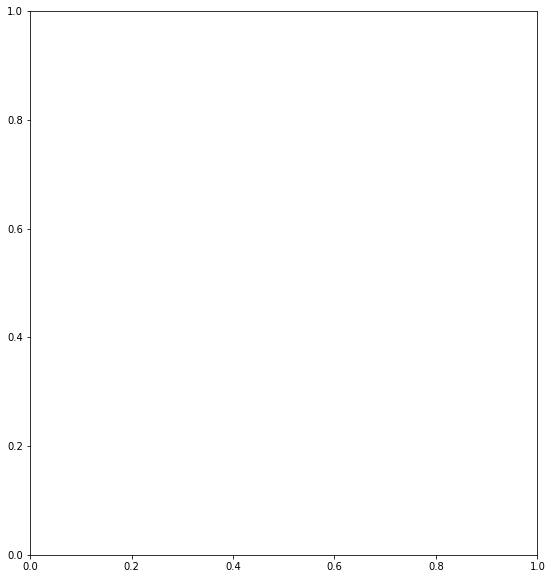

In [116]:
scores = [precision_at_N(N) for N in range(1,21)]

prec = [x[1] for x in scores]
rec = [x[0] for x in scores]

plt.figure(figsize=(20,10))

ax = plt.subplot(1,2,1)
ax.plot(np.linspace(1,21,num=20), rec, 'r-')
ax.set_xlabel('N')
ax.set_ylabel('recall(N)')
ax.set_title('Recall')

ax = plt.subplot(1,2,2)
ax.plot(rec, prec, 'r-')
ax.set_xlabel('recall')
ax.set_ylabel('precision')
ax.set_title('Precision vs recall')


### SVD++

In [40]:
#items rated by user u
R_u = {u:user_item_matrix.columns[~user_item_matrix.loc[u].isna()] for u in user_item_matrix.index.values}
R_u_idx = {u:user_item_matrix.columns.isin(R_u[u]) for u in R_u.keys()}

In [37]:
bu = np.load('saved/svdpp/bu.npy')
bi = np.load('saved/svdpp/bi.npy')
pu = np.load('saved/svdpp/pu.npy')
qi = np.load('saved/svdpp/qi.npy')
yj = np.load('saved/svdpp/yj.npy')

mu = user_item_matrix.mean().mean()

In [13]:
#hyperparams
init_mu = 0
init_sigma = 0.1
latent_dim = 200
n_epochs = 20
gamma = 0.007
lamb_bias = 0.02
lamb_latent = 0.02


#variables
bu = np.zeros(user_item_matrix.shape[0])
bi = np.zeros(user_item_matrix.shape[1])
pu = np.random.normal(init_mu, init_sigma, (user_item_matrix.shape[0], latent_dim))
qi = np.random.normal(init_mu, init_sigma, (user_item_matrix.shape[1], latent_dim))
yj = np.random.normal(init_mu, init_sigma, (user_item_matrix.shape[1], latent_dim))
mu = user_item_matrix.mean().mean()


# algorithm
for epoch in tqdm(range(n_epochs)):
    for i in user_item_matrix.columns.values:
        for u in user_item_matrix[~user_item_matrix[i].isna()].index.values:
            ii = i2idx[i]
            uu = u2idx[u]
            r = user_item_matrix[i].loc[u]
            
            wt = np.sqrt(R_u[u].shape[0])
            implicit_fbck = np.sum(yj[R_u_idx[u], :])/wt
            err = r - (mu + bu[uu] + bi[ii] + np.dot(qi[ii, :].T, pu[uu,:] + implicit_fbck))
            
            bu[uu] += gamma*(err-lamb_bias*bu[uu])
            bi[ii] += gamma*(err-lamb_bias*bi[ii])
            
            qi[ii,:] += gamma*(err*(pu[uu,:] + implicit_fbck) - lamb_latent*qi[ii,:])
            pu[uu,:] += gamma*(err*qi[ii,:] - lamb_latent*pu[uu,:])
            yj[ii,:] += gamma*(err/wt*qi[ii,:] - lamb_latent*yj[ii,:])

E:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in multiply
E:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in multiply
E:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in subtract


In [14]:
np.save('saved/svdpp/bu.npy', bu)
np.save('saved/svdpp/bi.npy', bi)
np.save('saved/svdpp/pu.npy', pu)
np.save('saved/svdpp/qi.npy', qi)
np.save('saved/svdpp/yj.npy', yj)

In [41]:
def predict(u, i):
    uu = u2idx[u]
    ii = i2idx[i]
    
    wt = np.sqrt(R_u[u].shape[0])
    implicit_fbck = np.sum(yj[R_u_idx[u]])/wt
    return mu + bi[ii] + bu[uu] + np.dot(qi[ii, :].T, pu[uu,:]+implicit_fbck)

In [42]:
predict(10,2)

nan